# Search-1 : Espaces d'etats et formulation de problemes

**Navigation** : [Index](../README.md) | [Suivant >>](Search-2-Uninformed.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Definir** formellement un probleme de recherche comme un 5-tuple (S, s0, A, T, G)
2. **Modeliser** des problemes concrets (aspirateur, taquin, itineraire) comme des espaces d'etats
3. **Implementer** en Python les composants d'un probleme de recherche (etats, actions, transitions)
4. **Analyser** les proprietes d'un espace d'etats (taille, observabilite, determinisme)

### Prerequis
- Python 3.10+ (bases du langage)
- Structures de donnees de base (listes, dictionnaires, ensembles)
- Notions elementaires de theorie des graphes

### Duree estimee : 40 minutes

## 1. Introduction

### Qu'est-ce qu'un probleme de recherche ?

Un **probleme de recherche** consiste a trouver une sequence d'actions menant d'une situation initiale a une situation desiree. Ce cadre general permet de modeliser un grand nombre de problemes :

| Domaine | Probleme | Etat | Action |
|---------|----------|------|--------|
| Navigation | GPS, itineraire | Position actuelle | Se deplacer vers une ville voisine |
| Jeux | Taquin, echecs | Configuration du plateau | Deplacer une piece |
| Planification | Robot, logistique | Configuration du monde | Executer une action |
| Optimisation | Emploi du temps | Affectation partielle | Assigner une ressource |

### Pourquoi formaliser ?

La formalisation d'un probleme en **espace d'etats** offre plusieurs avantages :
- **Generalite** : un seul algorithme (BFS, A*, etc.) peut resoudre de nombreux problemes differents
- **Rigueur** : la solution est un chemin verifiable dans un graphe bien defini
- **Analyse** : on peut raisonner sur la completude, l'optimalite et la complexite

> **Reference** : Ce notebook suit le chapitre 3 de *Artificial Intelligence: A Modern Approach* (Russell & Norvig).

In [1]:
# Imports
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
from typing import Any, List, Set, Tuple, Optional, Callable
from copy import deepcopy

# Optionnel : networkx pour la visualisation de graphes
try:
    import networkx as nx
    HAS_NETWORKX = True
except ImportError:
    HAS_NETWORKX = False
    print("networkx non disponible. Installer avec : pip install networkx")

print("Environnement pret.")

Environnement pret.


## 2. Formalisation d'un probleme de recherche

### Le 5-tuple $(S, s_0, A, T, G)$

Un probleme de recherche se definit formellement par cinq composants :

| Composant | Notation | Description |
|-----------|----------|-------------|
| **Espace d'etats** | $S$ | Ensemble de toutes les configurations possibles |
| **Etat initial** | $s_0 \in S$ | Configuration de depart |
| **Actions** | $A(s)$ | Ensemble des actions applicables dans l'etat $s$ |
| **Fonction de transition** | $T(s, a) \to s'$ | Etat resultant de l'action $a$ dans l'etat $s$ |
| **Test de but** | $G(s) \to \{vrai, faux\}$ | Determine si $s$ est un etat objectif |

On ajoute souvent une **fonction de cout** $c(s, a, s') \geq 0$ qui associe un cout a chaque transition.

### Solutions

- Une **solution** est un chemin $(s_0, a_1, s_1, a_2, ..., a_n, s_n)$ tel que $G(s_n) = vrai$
- Le **cout d'une solution** est $\sum_{i=1}^{n} c(s_{i-1}, a_i, s_i)$
- Une **solution optimale** est une solution de cout minimal

### Classe abstraite

Nous allons d'abord definir une classe abstraite `SearchProblem` qui capture cette formalisation. Chaque probleme concret heritera de cette classe.

In [2]:
class SearchProblem:
    """
    Classe abstraite representant un probleme de recherche.
    
    Correspond au 5-tuple (S, s0, A, T, G) avec cout optionnel.
    """
    
    def initial_state(self):
        """Retourne l'etat initial s0."""
        raise NotImplementedError
    
    def actions(self, state) -> List:
        """Retourne la liste des actions applicables dans l'etat donne."""
        raise NotImplementedError
    
    def transition(self, state, action):
        """Retourne l'etat resultant de l'application de l'action."""
        raise NotImplementedError
    
    def is_goal(self, state) -> bool:
        """Teste si l'etat est un etat objectif."""
        raise NotImplementedError
    
    def cost(self, state, action, next_state) -> float:
        """Cout de la transition (defaut = 1 pour chaque action)."""
        return 1.0
    
    def state_space_size(self) -> Optional[int]:
        """Taille de l'espace d'etats (si calculable)."""
        return None
    
    def __repr__(self):
        size = self.state_space_size()
        size_str = f", |S|={size}" if size else ""
        return f"SearchProblem({self.__class__.__name__}{size_str})"


print("Classe SearchProblem definie.")
print("Methodes : initial_state(), actions(s), transition(s,a), is_goal(s), cost(s,a,s')")

Classe SearchProblem definie.
Methodes : initial_state(), actions(s), transition(s,a), is_goal(s), cost(s,a,s')


## 3. Exemple 1 : Le monde de l'aspirateur

### Description

Le **monde de l'aspirateur** (Vacuum World) est un probleme classique de Russell & Norvig :

- **2 pieces** : Gauche (G) et Droite (D)
- Chaque piece peut etre **propre** ou **sale**
- L'aspirateur se trouve dans une des deux pieces
- **Actions** : Aspirer, Aller a gauche, Aller a droite
- **Objectif** : les deux pieces doivent etre propres

### Espace d'etats

Un etat est un triplet : (position, etat_gauche, etat_droite)
- Position : G ou D (2 valeurs)
- Etat de chaque piece : propre ou sale (2 valeurs chacune)
- **Nombre total d'etats** : $2 \times 2 \times 2 = 8$

In [3]:
class VacuumWorld(SearchProblem):
    """
    Monde de l'aspirateur a 2 pieces.
    
    Etat : (position, gauche_sale, droite_sale)
        - position: 'G' (gauche) ou 'D' (droite)
        - gauche_sale: True si la piece gauche est sale
        - droite_sale: True si la piece droite est sale
    """
    
    def __init__(self, position='G', gauche_sale=True, droite_sale=True):
        self.start = (position, gauche_sale, droite_sale)
    
    def initial_state(self):
        return self.start
    
    def actions(self, state) -> List[str]:
        """Actions possibles : Aspirer, Gauche, Droite."""
        pos, g_sale, d_sale = state
        acts = ['Aspirer']
        if pos == 'G':
            acts.append('Droite')
        else:
            acts.append('Gauche')
        return acts
    
    def transition(self, state, action):
        pos, g_sale, d_sale = state
        if action == 'Aspirer':
            if pos == 'G':
                return (pos, False, d_sale)
            else:
                return (pos, g_sale, False)
        elif action == 'Droite':
            return ('D', g_sale, d_sale)
        elif action == 'Gauche':
            return ('G', g_sale, d_sale)
        return state
    
    def is_goal(self, state) -> bool:
        _, g_sale, d_sale = state
        return not g_sale and not d_sale
    
    def state_space_size(self) -> int:
        return 8  # 2 positions x 2 etats gauche x 2 etats droite
    
    def all_states(self) -> List[tuple]:
        """Enumere tous les etats possibles."""
        states = []
        for pos in ['G', 'D']:
            for g in [False, True]:
                for d in [False, True]:
                    states.append((pos, g, d))
        return states


# Creation du probleme
vacuum = VacuumWorld(position='G', gauche_sale=True, droite_sale=True)
s0 = vacuum.initial_state()

print(f"Probleme : {vacuum}")
print(f"Etat initial : {s0}")
print(f"  -> Position: {s0[0]}, Gauche sale: {s0[1]}, Droite sale: {s0[2]}")
print(f"Actions possibles : {vacuum.actions(s0)}")
print(f"Est-ce un but ? {vacuum.is_goal(s0)}")
print(f"Taille de l'espace d'etats : {vacuum.state_space_size()}")

Probleme : SearchProblem(VacuumWorld, |S|=8)
Etat initial : ('G', True, True)
  -> Position: G, Gauche sale: True, Droite sale: True
Actions possibles : ['Aspirer', 'Droite']
Est-ce un but ? False
Taille de l'espace d'etats : 8


### Interpretation : Etat initial du monde de l'aspirateur

**Sortie obtenue** : L'aspirateur demarre dans la piece gauche, les deux pieces sont sales.

| Composant | Valeur | Description |
|-----------|--------|-------------|
| Position | G | L'aspirateur est dans la piece gauche |
| Gauche sale | True | La piece gauche contient de la salete |
| Droite sale | True | La piece droite contient de la salete |
| Actions | [Aspirer, Droite] | Aspirer sur place ou se deplacer a droite |
| But atteint | Non | Les deux pieces doivent etre propres |

**Point cle** : L'action "Gauche" n'est pas disponible car l'aspirateur est deja dans la piece gauche. Les actions dependent de l'etat courant.

### Trace d'execution

Simulons une sequence d'actions pour resoudre le probleme et observons l'evolution de l'etat.

In [4]:
def trace_solution(problem: SearchProblem, actions: List[str]):
    """Execute une sequence d'actions et affiche la trace."""
    state = problem.initial_state()
    total_cost = 0.0
    
    print(f"{'Etape':<8} {'Action':<12} {'Etat resultant':<30} {'But ?':<8} {'Cout cumule':<12}")
    print("-" * 70)
    print(f"{'init':<8} {'-':<12} {str(state):<30} {str(problem.is_goal(state)):<8} {total_cost:<12.1f}")
    
    for i, action in enumerate(actions, 1):
        next_state = problem.transition(state, action)
        step_cost = problem.cost(state, action, next_state)
        total_cost += step_cost
        is_goal = problem.is_goal(next_state)
        
        print(f"{i:<8} {action:<12} {str(next_state):<30} {str(is_goal):<8} {total_cost:<12.1f}")
        
        state = next_state
        if is_goal:
            print(f"\nSolution trouvee en {i} etapes, cout total = {total_cost}")
            return True
    
    print(f"\nSequence terminee sans atteindre le but.")
    return False


# Solution optimale
print("Solution optimale :\n")
trace_solution(vacuum, ['Aspirer', 'Droite', 'Aspirer'])

Solution optimale :

Etape    Action       Etat resultant                 But ?    Cout cumule 
----------------------------------------------------------------------
init     -            ('G', True, True)              False    0.0         
1        Aspirer      ('G', False, True)             False    1.0         
2        Droite       ('D', False, True)             False    2.0         
3        Aspirer      ('D', False, False)            True     3.0         

Solution trouvee en 3 etapes, cout total = 3.0


True

### Interpretation : Solution du monde de l'aspirateur

**Sortie obtenue** : La solution optimale est Aspirer, Droite, Aspirer en 3 etapes.

| Etape | Etat avant | Action | Etat apres | Effet |
|-------|------------|--------|------------|-------|
| 1 | (G, sale, sale) | Aspirer | (G, propre, sale) | Nettoie la piece gauche |
| 2 | (G, propre, sale) | Droite | (D, propre, sale) | Se deplace sans nettoyer |
| 3 | (D, propre, sale) | Aspirer | (D, propre, propre) | Nettoie la piece droite |

**Points cles** :
1. La solution a un cout de 3 (une unite par action)
2. C'est une solution **optimale** : on ne peut pas nettoyer les deux pieces en moins de 3 actions
3. La sequence (Droite, Aspirer, Gauche, Aspirer) est aussi une solution valide, mais de cout 4

### Visualisation du graphe d'etats

Avec seulement 8 etats, nous pouvons visualiser l'integralite de l'espace d'etats sous forme de graphe oriente.

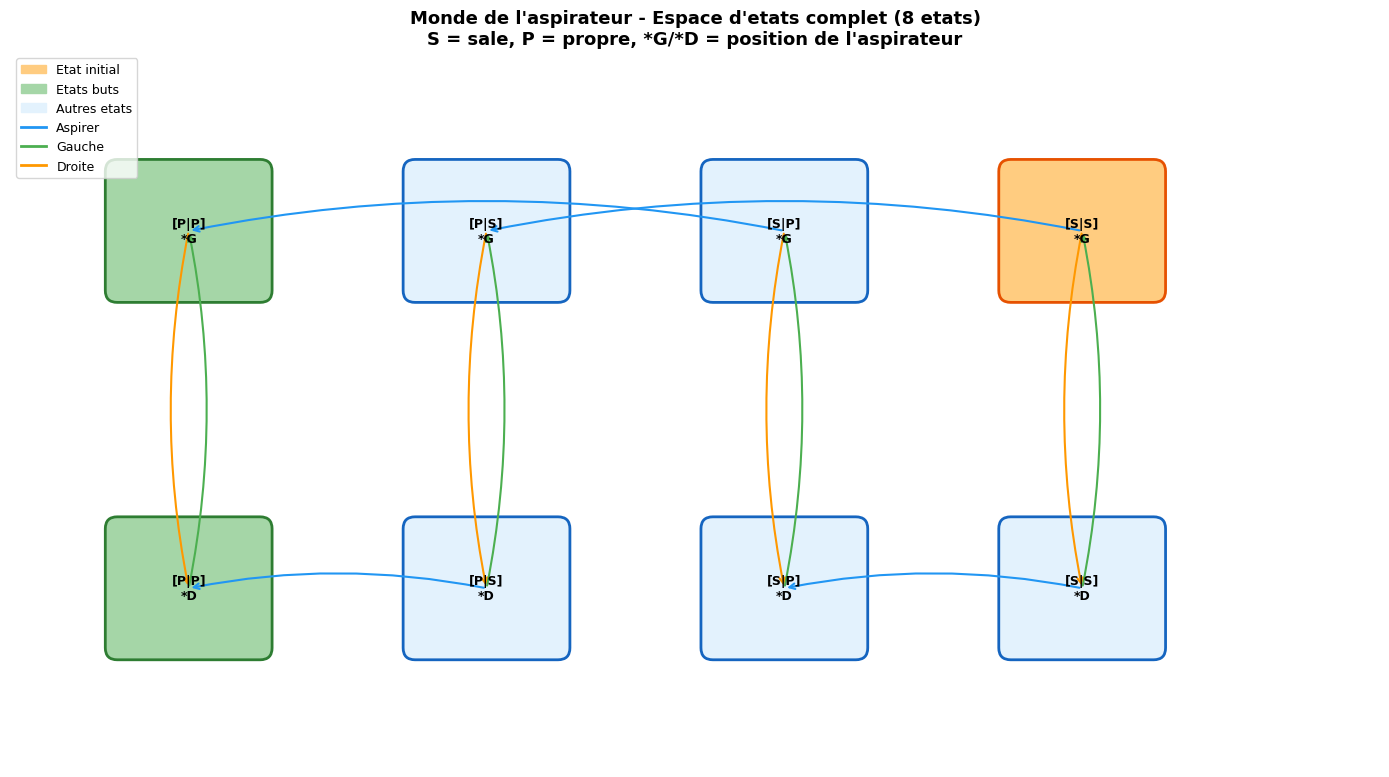

In [5]:
def visualize_vacuum_state_space(problem: VacuumWorld):
    """Visualise l'espace d'etats complet du monde de l'aspirateur."""
    all_states = problem.all_states()
    
    # Construire le graphe des transitions
    edges = []  # (source, target, action)
    for s in all_states:
        for a in problem.actions(s):
            s_prime = problem.transition(s, a)
            if s != s_prime:  # Ignorer les auto-boucles triviales
                edges.append((s, s_prime, a))
    
    # Representation textuelle des etats
    def state_label(s):
        pos, g, d = s
        g_str = "S" if g else "P"
        d_str = "S" if d else "P"
        return f"[{g_str}|{d_str}]\n*{pos}"
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Disposition manuelle en grille 2x4
    # Ligne du haut : aspirateur a Gauche, Ligne du bas : aspirateur a Droite
    positions = {}
    idx = 0
    for pos in ['G', 'D']:
        row = 0 if pos == 'G' else 1
        col = 0
        for g in [False, True]:
            for d in [False, True]:
                state = (pos, g, d)
                x = col * 2.5 + 1
                y = (1 - row) * 3 + 1
                positions[state] = (x, y)
                col += 1
    
    # Dessiner les aretes
    action_colors = {'Aspirer': '#2196F3', 'Gauche': '#4CAF50', 'Droite': '#FF9800'}
    drawn = set()
    for s, s_prime, a in edges:
        key = (s, s_prime)
        if key in drawn:
            continue
        drawn.add(key)
        x1, y1 = positions[s]
        x2, y2 = positions[s_prime]
        color = action_colors.get(a, 'gray')
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', color=color, lw=1.5, 
                                   connectionstyle='arc3,rad=0.1'))
    
    # Dessiner les noeuds
    for state, (x, y) in positions.items():
        is_init = (state == problem.initial_state())
        is_goal = problem.is_goal(state)
        
        if is_goal:
            color = '#A5D6A7'  # Vert pour les buts
            ec = '#2E7D32'
        elif is_init:
            color = '#FFCC80'  # Orange pour l'initial
            ec = '#E65100'
        else:
            color = '#E3F2FD'  # Bleu clair
            ec = '#1565C0'
        
        rect = mpatches.FancyBboxPatch((x - 0.6, y - 0.5), 1.2, 1.0,
                                        boxstyle='round,pad=0.1',
                                        facecolor=color, edgecolor=ec, linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y, state_label(state), ha='center', va='center',
                fontsize=9, fontweight='bold')
    
    # Legende
    legend_patches = [
        mpatches.Patch(color='#FFCC80', label='Etat initial'),
        mpatches.Patch(color='#A5D6A7', label='Etats buts'),
        mpatches.Patch(color='#E3F2FD', label='Autres etats'),
    ]
    legend_lines = [
        plt.Line2D([0], [0], color='#2196F3', lw=2, label='Aspirer'),
        plt.Line2D([0], [0], color='#4CAF50', lw=2, label='Gauche'),
        plt.Line2D([0], [0], color='#FF9800', lw=2, label='Droite'),
    ]
    ax.legend(handles=legend_patches + legend_lines, loc='upper left', fontsize=9)
    
    ax.set_xlim(-0.5, 11)
    ax.set_ylim(-0.5, 5.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("Monde de l'aspirateur - Espace d'etats complet (8 etats)\n"
                 "S = sale, P = propre, *G/*D = position de l'aspirateur",
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


visualize_vacuum_state_space(vacuum)

### Interpretation : Graphe d'etats de l'aspirateur

**Sortie obtenue** : Le graphe complet montre les 8 etats et les transitions possibles.

| Observation | Detail |
|-------------|--------|
| Etats buts | 2 etats (vert) : (G, propre, propre) et (D, propre, propre) |
| Etat initial | 1 etat (orange) : (G, sale, sale) |
| Transitions Aspirer | Vont vers des etats avec moins de salete (fleches bleues) |
| Transitions Gauche/Droite | Changent uniquement la position (fleches vertes/orange) |

**Points cles** :
1. L'action "Aspirer" dans une piece deja propre ne change pas l'etat (auto-boucle, non affichee)
2. Depuis l'etat initial, il y a exactement **2 chemins optimaux** de longueur 3 vers un but
3. Le graphe est **connexe** : depuis tout etat, on peut atteindre un etat but

## 4. Exemple 2 : Le taquin (8-Puzzle)

### Description

Le **taquin** (8-Puzzle) est un casse-tete classique :
- Une grille 3x3 contenant 8 tuiles numerotees (1 a 8) et une case vide
- On deplace les tuiles en glissant dans la case vide
- **Objectif** : atteindre une configuration cible (1 a 8 en ordre)

### Modelisation

| Composant | Definition |
|-----------|------------|
| Etat | Tuple de 9 elements (0 = case vide) |
| Actions | Haut, Bas, Gauche, Droite (deplace la case vide) |
| Transition | Echange la case vide avec la tuile adjacente |
| But | Configuration $(1, 2, 3, 4, 5, 6, 7, 8, 0)$ |
| Taille | $\frac{9!}{2} = 181\,440$ etats accessibles |

In [6]:
class EightPuzzle(SearchProblem):
    """
    Le taquin (8-Puzzle).
    
    Etat : tuple de 9 entiers, 0 represente la case vide.
    Exemple : (1, 2, 3, 4, 5, 6, 7, 8, 0) = etat but.
    """
    
    GOAL = (1, 2, 3, 4, 5, 6, 7, 8, 0)
    
    # Mouvements possibles de la case vide selon sa position (index 0-8)
    MOVES = {
        0: {'Bas': 3, 'Droite': 1},
        1: {'Bas': 4, 'Gauche': 0, 'Droite': 2},
        2: {'Bas': 5, 'Gauche': 1},
        3: {'Haut': 0, 'Bas': 6, 'Droite': 4},
        4: {'Haut': 1, 'Bas': 7, 'Gauche': 3, 'Droite': 5},
        5: {'Haut': 2, 'Bas': 8, 'Gauche': 4},
        6: {'Haut': 3, 'Droite': 7},
        7: {'Haut': 4, 'Gauche': 6, 'Droite': 8},
        8: {'Haut': 5, 'Gauche': 7},
    }
    
    def __init__(self, start: tuple = None):
        if start is None:
            start = (7, 2, 4, 5, 0, 6, 8, 3, 1)  # Exemple de configuration
        self.start = start
    
    def initial_state(self):
        return self.start
    
    def actions(self, state) -> List[str]:
        blank_pos = state.index(0)
        return list(self.MOVES[blank_pos].keys())
    
    def transition(self, state, action):
        blank_pos = state.index(0)
        target_pos = self.MOVES[blank_pos][action]
        state_list = list(state)
        state_list[blank_pos], state_list[target_pos] = state_list[target_pos], state_list[blank_pos]
        return tuple(state_list)
    
    def is_goal(self, state) -> bool:
        return state == self.GOAL
    
    def state_space_size(self) -> int:
        # 9!/2 (la moitie des permutations sont atteignables)
        import math
        return math.factorial(9) // 2


# Creation
puzzle = EightPuzzle(start=(7, 2, 4, 5, 0, 6, 8, 3, 1))
s0 = puzzle.initial_state()

print(f"Taille de l'espace d'etats : {puzzle.state_space_size():,} etats")
print(f"Etat initial : {s0}")
print(f"Etat but :     {EightPuzzle.GOAL}")
print(f"Actions depuis l'etat initial : {puzzle.actions(s0)}")

Taille de l'espace d'etats : 181,440 etats
Etat initial : (7, 2, 4, 5, 0, 6, 8, 3, 1)
Etat but :     (1, 2, 3, 4, 5, 6, 7, 8, 0)
Actions depuis l'etat initial : ['Haut', 'Bas', 'Gauche', 'Droite']


### Affichage visuel du taquin

Pour mieux comprendre le probleme, affichons les etats du taquin sous forme de grilles graphiques.

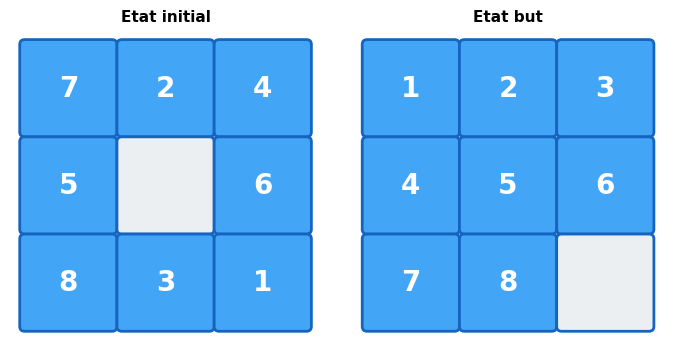

In [7]:
def draw_puzzle_state(state: tuple, ax=None, title=""):
    """Affiche un etat du taquin sous forme de grille 3x3."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    
    for i in range(9):
        row, col = divmod(i, 3)
        value = state[i]
        
        if value == 0:
            color = '#ECEFF1'  # Gris clair pour case vide
            text_color = '#ECEFF1'
        else:
            color = '#42A5F5'  # Bleu pour les tuiles
            text_color = 'white'
        
        rect = mpatches.FancyBboxPatch((col - 0.45, 2 - row - 0.45), 0.9, 0.9,
                                        boxstyle='round,pad=0.05',
                                        facecolor=color, edgecolor='#1565C0',
                                        linewidth=2)
        ax.add_patch(rect)
        
        if value != 0:
            ax.text(col, 2 - row, str(value), ha='center', va='center',
                    fontsize=20, fontweight='bold', color=text_color)
    
    ax.set_xlim(-0.6, 2.6)
    ax.set_ylim(-0.6, 2.6)
    ax.set_aspect('equal')
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=11, fontweight='bold')


def draw_puzzle_sequence(states: List[tuple], actions: List[str] = None, title=""):
    """Affiche une sequence d'etats du taquin."""
    n = len(states)
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3.5))
    if n == 1:
        axes = [axes]
    
    for i, (state, ax) in enumerate(zip(states, axes)):
        step_title = f"Etape {i}"
        if actions and i > 0:
            step_title += f"\n({actions[i-1]})"
        elif i == 0:
            step_title = "Initial"
        draw_puzzle_state(state, ax, step_title)
    
    fig.suptitle(title, fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Afficher l'etat initial et le but
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))
draw_puzzle_state(puzzle.initial_state(), axes[0], "Etat initial")
draw_puzzle_state(EightPuzzle.GOAL, axes[1], "Etat but")
plt.tight_layout()
plt.show()

### Exploration de quelques mouvements

Appliquons quelques actions depuis l'etat initial pour observer les transitions.

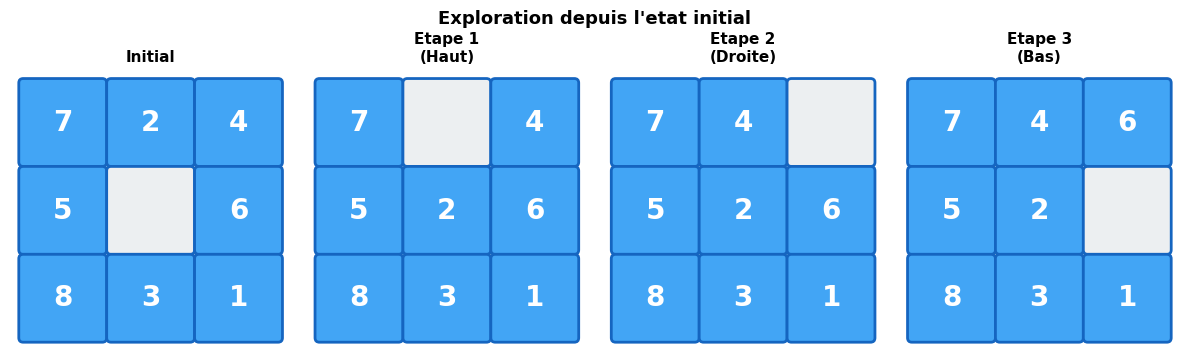

Facteur de branchement selon la position de la case vide :
  Coin (positions 0,2,6,8) : 2 actions
  Bord (positions 1,3,5,7) : 3 actions
  Centre (position 4)      : 4 actions
  Facteur de branchement moyen : 2.67


In [8]:
# Simuler quelques mouvements
s0 = puzzle.initial_state()
actions_demo = ['Haut', 'Droite', 'Bas']

states_seq = [s0]
current = s0
for a in actions_demo:
    current = puzzle.transition(current, a)
    states_seq.append(current)

# Afficher la sequence
draw_puzzle_sequence(states_seq, actions_demo, "Exploration depuis l'etat initial")

# Montrer le facteur de branchement
print("Facteur de branchement selon la position de la case vide :")
print(f"  Coin (positions 0,2,6,8) : 2 actions")
print(f"  Bord (positions 1,3,5,7) : 3 actions")
print(f"  Centre (position 4)      : 4 actions")
print(f"  Facteur de branchement moyen : {(4*2 + 4*3 + 1*4)/9:.2f}")

### Interpretation : Transitions du taquin

**Sortie obtenue** : Trois mouvements successifs de la case vide, avec le facteur de branchement.

| Propriete | Valeur | Consequence |
|-----------|--------|-------------|
| Facteur de branchement moyen | ~2.67 | L'arbre de recherche croit rapidement |
| Espace d'etats | 181 440 | Grand mais fini, explorable par BFS/DFS |
| Solution optimale typique | 20-30 coups | Difficulte variable selon la configuration initiale |

**Points cles** :
1. Les actions "Haut", "Bas", "Gauche", "Droite" deplacent la **case vide**, pas une tuile specifique
2. Le nombre d'actions varie de 2 (coin) a 4 (centre)
3. La profondeur maximale de la solution optimale pour le 8-puzzle est de 31 coups

> **Note** : Le 15-puzzle (grille 4x4) a environ $10^{13}$ etats et le 24-puzzle (grille 5x5) environ $10^{25}$ etats.

## 5. Exemple 3 : Recherche d'itineraire

### Description

Le probleme de **recherche d'itineraire** consiste a trouver le chemin le plus court entre deux villes dans un reseau routier. C'est l'application la plus intuitive de la recherche dans un espace d'etats.

### Modelisation

| Composant | Definition |
|-----------|------------|
| Etat | Ville actuelle |
| Actions | Se deplacer vers une ville voisine |
| Transition | Changer de ville |
| Cout | Distance entre les deux villes |
| But | Arriver a la ville de destination |

In [9]:
class RouteFinding(SearchProblem):
    """
    Probleme de recherche d'itineraire dans un graphe de villes.
    
    Le graphe est represente par un dictionnaire d'adjacence
    avec les distances entre villes voisines.
    """
    
    def __init__(self, graph: dict, start: str, goal: str):
        """
        Args:
            graph: dict {ville: [(voisin, distance), ...]}
            start: ville de depart
            goal: ville d'arrivee
        """
        self.graph = graph
        self.start_city = start
        self.goal_city = goal
    
    def initial_state(self):
        return self.start_city
    
    def actions(self, state) -> List[str]:
        return [neighbor for neighbor, _ in self.graph.get(state, [])]
    
    def transition(self, state, action):
        return action  # L'action est la ville de destination
    
    def is_goal(self, state) -> bool:
        return state == self.goal_city
    
    def cost(self, state, action, next_state) -> float:
        for neighbor, distance in self.graph.get(state, []):
            if neighbor == next_state:
                return distance
        return float('inf')
    
    def state_space_size(self) -> int:
        return len(self.graph)


# Reseau de villes francaises (distances approximatives en km)
france_graph = {
    'Paris':      [('Lyon', 465), ('Lille', 225), ('Strasbourg', 490), ('Nantes', 385), ('Bordeaux', 585)],
    'Lyon':       [('Paris', 465), ('Marseille', 315), ('Grenoble', 105), ('Strasbourg', 490)],
    'Marseille':  [('Lyon', 315), ('Montpellier', 170), ('Nice', 200)],
    'Lille':      [('Paris', 225), ('Strasbourg', 525)],
    'Strasbourg': [('Paris', 490), ('Lyon', 490), ('Lille', 525)],
    'Bordeaux':   [('Paris', 585), ('Toulouse', 245), ('Nantes', 345)],
    'Toulouse':   [('Bordeaux', 245), ('Montpellier', 245)],
    'Montpellier':[('Toulouse', 245), ('Marseille', 170)],
    'Nantes':     [('Paris', 385), ('Bordeaux', 345)],
    'Nice':       [('Marseille', 200)],
    'Grenoble':   [('Lyon', 105)],
}

# Probleme : aller de Bordeaux a Strasbourg
route = RouteFinding(france_graph, 'Bordeaux', 'Strasbourg')

print(f"Depart : {route.start_city}")
print(f"Arrivee : {route.goal_city}")
print(f"Nombre de villes : {route.state_space_size()}")
print(f"Actions depuis Bordeaux : {route.actions('Bordeaux')}")
print(f"Cout Bordeaux -> Paris : {route.cost('Bordeaux', 'Paris', 'Paris')} km")

Depart : Bordeaux
Arrivee : Strasbourg
Nombre de villes : 11
Actions depuis Bordeaux : ['Paris', 'Toulouse', 'Nantes']
Cout Bordeaux -> Paris : 585 km


### Visualisation de la carte

Utilisons networkx pour afficher le reseau routier sous forme de graphe avec les distances.

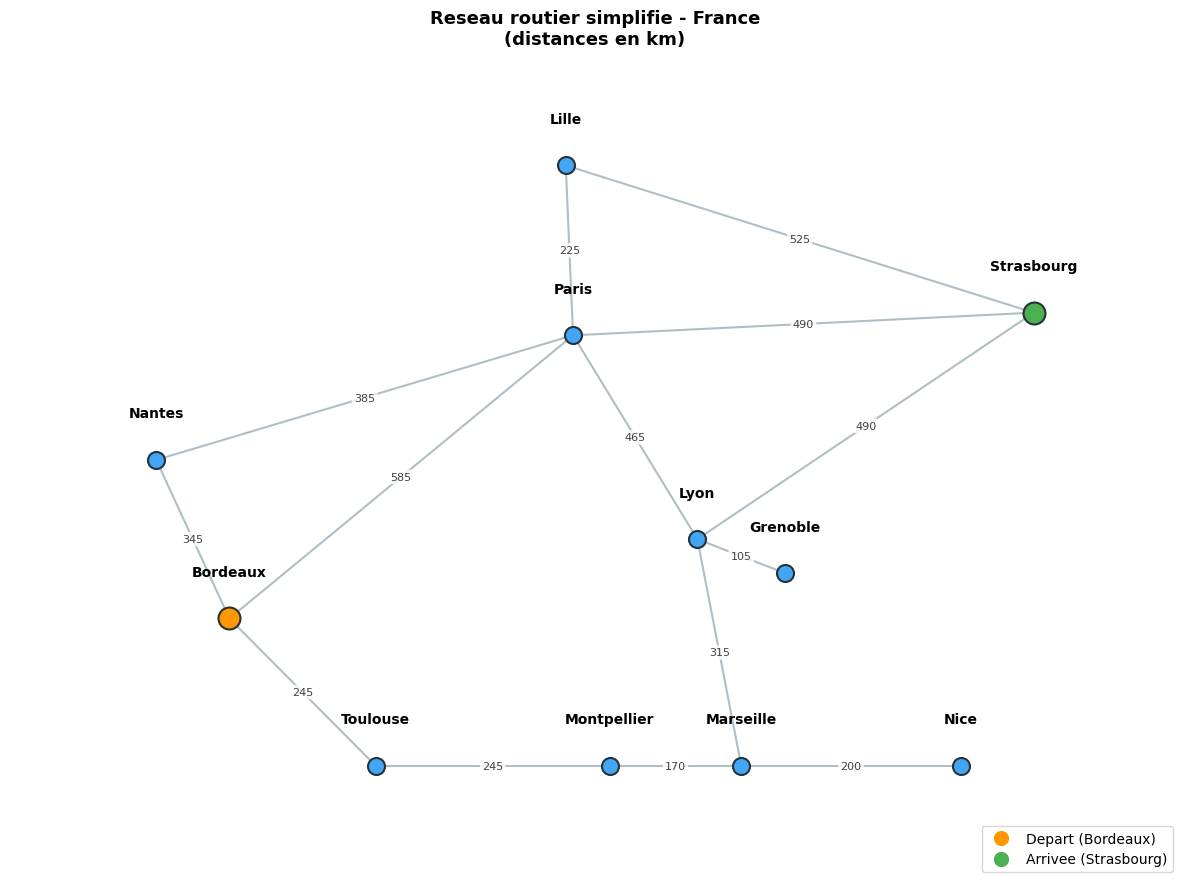

In [10]:
def visualize_route_graph(graph: dict, start: str = None, goal: str = None,
                          path: List[str] = None):
    """Visualise le graphe routier avec positions geographiques approximatives."""
    
    # Positions approximatives (longitude, latitude normalisees)
    city_positions = {
        'Paris':       (2.35, 6.3),
        'Lyon':        (3.2, 4.5),
        'Marseille':   (3.5, 2.5),
        'Lille':       (2.3, 7.8),
        'Strasbourg':  (5.5, 6.5),
        'Bordeaux':    (0.0, 3.8),
        'Toulouse':    (1.0, 2.5),
        'Montpellier': (2.6, 2.5),
        'Nantes':      (-0.5, 5.2),
        'Nice':        (5.0, 2.5),
        'Grenoble':    (3.8, 4.2),
    }
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Dessiner les aretes
    drawn_edges = set()
    for city, neighbors in graph.items():
        for neighbor, dist in neighbors:
            edge_key = tuple(sorted([city, neighbor]))
            if edge_key not in drawn_edges:
                drawn_edges.add(edge_key)
                x1, y1 = city_positions[city]
                x2, y2 = city_positions[neighbor]
                
                # Couleur speciale si dans le chemin
                is_path_edge = False
                if path:
                    for i in range(len(path) - 1):
                        if edge_key == tuple(sorted([path[i], path[i+1]])):
                            is_path_edge = True
                            break
                
                color = '#E53935' if is_path_edge else '#B0BEC5'
                lw = 3 if is_path_edge else 1.5
                
                ax.plot([x1, x2], [y1, y2], '-', color=color, linewidth=lw, zorder=1)
                
                # Distance au milieu de l'arete
                mx, my = (x1 + x2) / 2, (y1 + y2) / 2
                ax.text(mx, my, f"{dist}", ha='center', va='center',
                        fontsize=8, color='#424242',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                  edgecolor='none', alpha=0.8))
    
    # Dessiner les villes
    for city, (x, y) in city_positions.items():
        if city == start:
            color = '#FF9800'
            size = 250
        elif city == goal:
            color = '#4CAF50'
            size = 250
        elif path and city in path:
            color = '#E53935'
            size = 200
        else:
            color = '#42A5F5'
            size = 150
        
        ax.scatter(x, y, s=size, c=color, edgecolors='#263238', linewidth=1.5, zorder=3)
        ax.text(x, y + 0.35, city, ha='center', va='bottom',
                fontsize=10, fontweight='bold')
    
    # Legende
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF9800',
                   markersize=12, label=f'Depart ({start})' if start else 'Depart'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50',
                   markersize=12, label=f'Arrivee ({goal})' if goal else 'Arrivee'),
    ]
    if path:
        legend_elements.append(
            plt.Line2D([0], [0], color='#E53935', linewidth=3, label='Chemin')
        )
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    ax.set_xlim(-1.5, 6.5)
    ax.set_ylim(1.5, 8.8)
    ax.set_title("Reseau routier simplifie - France\n(distances en km)",
                 fontsize=13, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Afficher la carte
visualize_route_graph(france_graph, start='Bordeaux', goal='Strasbourg')

### Interpretation : Reseau routier

**Sortie obtenue** : La carte montre 11 villes et les liaisons routieres avec distances en km.

| Observation | Detail |
|-------------|--------|
| Depart (orange) | Bordeaux, sud-ouest |
| Arrivee (vert) | Strasbourg, est |
| Chemins possibles | Via Paris (Bordeaux-Paris-Strasbourg = 1075 km) |
| | Via Toulouse-Lyon (Bordeaux-Toulouse-Montpellier-Marseille-Lyon-Strasbourg) |

**Points cles** :
1. Le cout (distance) est **variable** : contrairement a l'aspirateur et au taquin, chaque action a un cout different
2. Le graphe n'est pas complet : toutes les villes ne sont pas directement reliees
3. La solution la plus courte en nombre d'etapes n'est pas forcement la plus courte en distance

### Comparaison de deux itineraires

Comparons un itineraire direct (peu d'etapes) et un itineraire avec plus d'etapes pour illustrer la difference entre nombre d'etapes et cout total.

In [11]:
def evaluate_path(problem: RouteFinding, path: List[str]):
    """Evalue un itineraire : cout total et nombre d'etapes."""
    total_cost = 0
    segments = []
    for i in range(len(path) - 1):
        c = problem.cost(path[i], path[i+1], path[i+1])
        total_cost += c
        segments.append((path[i], path[i+1], c))
    return total_cost, segments


# Itineraire 1 : via Paris (direct)
path1 = ['Bordeaux', 'Paris', 'Strasbourg']
cost1, segments1 = evaluate_path(route, path1)

# Itineraire 2 : via le sud
path2 = ['Bordeaux', 'Toulouse', 'Montpellier', 'Marseille', 'Lyon', 'Strasbourg']
cost2, segments2 = evaluate_path(route, path2)

print("Comparaison de deux itineraires Bordeaux -> Strasbourg")
print("=" * 60)

print(f"\nItineraire 1 : via Paris")
print(f"  Nombre d'etapes : {len(path1) - 1}")
for s, d, c in segments1:
    print(f"  {s} -> {d} : {c} km")
print(f"  Distance totale : {cost1} km")

print(f"\nItineraire 2 : via le sud")
print(f"  Nombre d'etapes : {len(path2) - 1}")
for s, d, c in segments2:
    print(f"  {s} -> {d} : {c} km")
print(f"  Distance totale : {cost2} km")

print(f"\nDifference : {abs(cost1 - cost2)} km")
print(f"Le chemin le plus court est l'itineraire {'1 (via Paris)' if cost1 <= cost2 else '2 (via le sud)'}")

Comparaison de deux itineraires Bordeaux -> Strasbourg

Itineraire 1 : via Paris
  Nombre d'etapes : 2
  Bordeaux -> Paris : 585 km
  Paris -> Strasbourg : 490 km
  Distance totale : 1075 km

Itineraire 2 : via le sud
  Nombre d'etapes : 5
  Bordeaux -> Toulouse : 245 km
  Toulouse -> Montpellier : 245 km
  Montpellier -> Marseille : 170 km
  Marseille -> Lyon : 315 km
  Lyon -> Strasbourg : 490 km
  Distance totale : 1465 km

Difference : 390 km
Le chemin le plus court est l'itineraire 1 (via Paris)


### Interpretation : Nombre d'etapes vs cout

**Sortie obtenue** : Deux itineraires de longueurs differentes en nombre d'etapes et en distance.

| Itineraire | Etapes | Distance totale | Commentaire |
|------------|--------|-----------------|-------------|
| Via Paris | 2 | 1075 km | Peu d'etapes, mais long |
| Via le sud | 5 | 1465 km | Plus d'etapes et plus long |

**Lecon fondamentale** : La distinction entre **recherche en largeur** (minimise le nombre d'etapes) et **recherche au cout uniforme** (minimise le cout total) est cruciale. Dans cet exemple :
- BFS choisirait l'itineraire 1 (2 etapes)
- La recherche au cout uniforme pourrait trouver un chemin moins cher en explorant d'autres options

> L'algorithme **A*** combine les deux en utilisant une heuristique pour guider la recherche. Nous l'etudierons dans le notebook suivant.

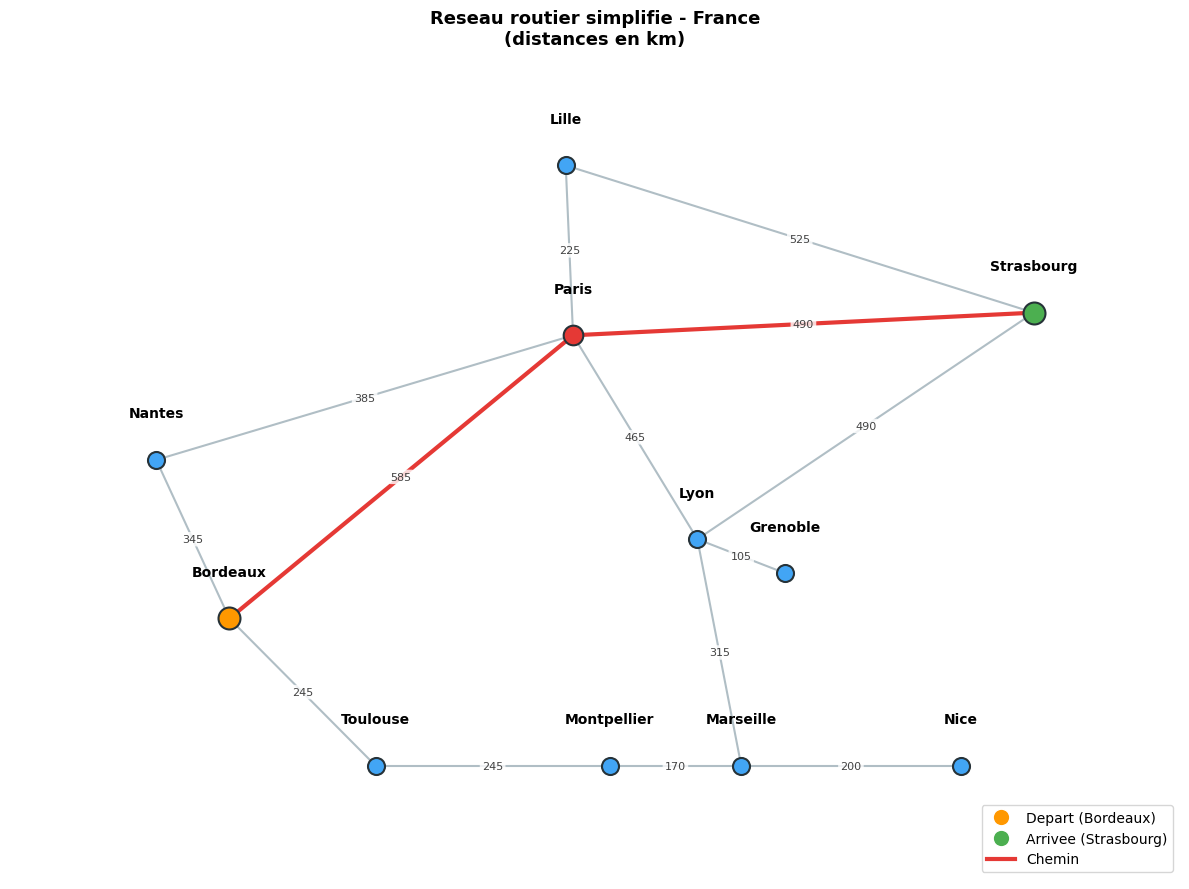

In [12]:
# Afficher le chemin via Paris sur la carte
visualize_route_graph(france_graph, start='Bordeaux', goal='Strasbourg',
                      path=['Bordeaux', 'Paris', 'Strasbourg'])

## 6. Proprietes des problemes de recherche

### Classification des problemes

Les problemes de recherche se distinguent par plusieurs proprietes qui influencent le choix de l'algorithme de resolution.

In [13]:
# Tableau comparatif des trois problemes
properties = [
    ["Propriete", "Aspirateur", "8-Puzzle", "Itineraire"],
    ["Observable", "Oui", "Oui", "Oui"],
    ["Deterministe", "Oui", "Oui", "Oui"],
    ["Discret", "Oui", "Oui", "Oui"],
    ["Statique", "Oui", "Oui", "Oui"],
    ["Agent unique", "Oui", "Oui", "Oui"],
    ["-" * 20, "-" * 15, "-" * 15, "-" * 15],
    ["Taille |S|", "8", "181 440", "Variable (~11)"],
    ["Facteur branch.", "~2", "~2.67", "Variable (~2.7)"],
    ["Cout uniforme", "Oui (1 par action)", "Oui (1 par action)", "Non (distances)"],
    ["Prof. solution", "2-3", "~22 (moy.)", "Variable"],
    ["Reversible", "Partiellement", "Oui", "Oui"],
]

# Affichage formate
print("Comparaison des trois problemes de recherche")
print("=" * 70)

for row in properties:
    print(f"{row[0]:<20} {row[1]:<15} {row[2]:<15} {row[3]:<15}")

Comparaison des trois problemes de recherche
Propriete            Aspirateur      8-Puzzle        Itineraire     
Observable           Oui             Oui             Oui            
Deterministe         Oui             Oui             Oui            
Discret              Oui             Oui             Oui            
Statique             Oui             Oui             Oui            
Agent unique         Oui             Oui             Oui            
-------------------- --------------- --------------- ---------------
Taille |S|           8               181 440         Variable (~11) 
Facteur branch.      ~2              ~2.67           Variable (~2.7)
Cout uniforme        Oui (1 par action) Oui (1 par action) Non (distances)
Prof. solution       2-3             ~22 (moy.)      Variable       
Reversible           Partiellement   Oui             Oui            


### Interpretation : Comparaison des proprietes

Les trois problemes partagent des proprietes importantes qui les rendent accessibles aux algorithmes de recherche classiques :

| Propriete | Signification | Consequence algorithmique |
|-----------|---------------|---------------------------|
| **Observable** | L'agent connait l'etat complet | Pas besoin de perception partielle |
| **Deterministe** | Chaque action a un resultat unique | Pas de probabilites a gerer |
| **Discret** | Nombre fini d'etats et d'actions | Enumeration possible |
| **Statique** | Le monde ne change pas entre les actions | L'agent peut planifier hors-ligne |
| **Agent unique** | Pas d'adversaire | Pas besoin de theorie des jeux |

**Differences significatives** :

| Difference | Impact |
|------------|--------|
| Taille de l'espace | Le 8-puzzle est 22 000 fois plus grand que l'aspirateur |
| Cout uniforme ou non | L'itineraire necessite UCS ou A* (BFS ne suffit pas pour l'optimalite) |
| Reversibilite | Le taquin est totalement reversible, l'aspirateur ne l'est que partiellement |

> **Problemes plus complexes** : Quand ces proprietes ne sont pas satisfaites (non-determinisme, observabilite partielle, multi-agents), il faut des algorithmes specialises (POMDP, jeux, planification probabiliste).

## 7. Exercices

### Exercice 1 : Missionnaires et Cannibales

Trois missionnaires et trois cannibales doivent traverser une riviere dans un bateau qui ne peut transporter que 2 personnes. Si les cannibales sont plus nombreux que les missionnaires sur une rive, les missionnaires sont devores.

**Tache** : Modelisez ce probleme comme un `SearchProblem`.

- Etat : `(m_gauche, c_gauche, bateau)` ou `m_gauche` = missionnaires sur la rive gauche, `c_gauche` = cannibales sur la rive gauche, `bateau` = 'G' ou 'D'
- Actions : nombre de missionnaires et cannibales dans le bateau
- Contrainte : jamais plus de cannibales que de missionnaires sur une rive (sauf si 0 missionnaires)

In [14]:
class MissionariesCannibals(SearchProblem):
    """
    Exercice 1 : Missionnaires et Cannibales.
    
    Etat : (missionnaires_gauche, cannibales_gauche, position_bateau)
    Etat initial : (3, 3, 'G')  - tout le monde a gauche
    But : (0, 0, 'D')           - tout le monde a droite
    """
    
    def initial_state(self):
        return (3, 3, 'G')
    
    def _is_valid(self, state) -> bool:
        """Verifie que l'etat est valide (pas de missionnaire devore)."""
        m_g, c_g, _ = state
        m_d, c_d = 3 - m_g, 3 - c_g
        # Verifier les bornes
        if not (0 <= m_g <= 3 and 0 <= c_g <= 3):
            return False
        # Missionnaires en securite sur chaque rive
        if m_g > 0 and m_g < c_g:
            return False
        if m_d > 0 and m_d < c_d:
            return False
        return True
    
    def actions(self, state) -> List[Tuple[int, int]]:
        """Retourne les actions possibles : (missionnaires, cannibales) dans le bateau."""
        m_g, c_g, boat = state
        possible = []
        # Toutes les combinaisons de 1 ou 2 personnes
        for m in range(3):
            for c in range(3):
                if 1 <= m + c <= 2:
                    if boat == 'G' and m <= m_g and c <= c_g:
                        new_state = (m_g - m, c_g - c, 'D')
                        if self._is_valid(new_state):
                            possible.append((m, c))
                    elif boat == 'D' and m <= (3 - m_g) and c <= (3 - c_g):
                        new_state = (m_g + m, c_g + c, 'G')
                        if self._is_valid(new_state):
                            possible.append((m, c))
        return possible
    
    def transition(self, state, action):
        m_g, c_g, boat = state
        m, c = action
        if boat == 'G':
            return (m_g - m, c_g - c, 'D')
        else:
            return (m_g + m, c_g + c, 'G')
    
    def is_goal(self, state) -> bool:
        return state == (0, 0, 'D')
    
    def state_space_size(self) -> int:
        # Nombre d'etats valides
        count = 0
        for m in range(4):
            for c in range(4):
                for b in ['G', 'D']:
                    if self._is_valid((m, c, b)):
                        count += 1
        return count


# Test
mc = MissionariesCannibals()
s0 = mc.initial_state()
print(f"Etat initial : {s0} (3M, 3C a gauche, bateau a gauche)")
print(f"Nombre d'etats valides : {mc.state_space_size()}")
print(f"Actions possibles : {mc.actions(s0)}")
print("  (m, c) = nombre de missionnaires et cannibales dans le bateau")

Etat initial : (3, 3, 'G') (3M, 3C a gauche, bateau a gauche)
Nombre d'etats valides : 20
Actions possibles : [(0, 1), (0, 2), (1, 1)]
  (m, c) = nombre de missionnaires et cannibales dans le bateau


#### Solution de l'exercice 1

Utilisons une recherche en largeur (BFS) simple pour trouver la solution.

In [15]:
def bfs_solve(problem: SearchProblem):
    """Recherche en largeur simple (BFS) pour trouver une solution."""
    start = problem.initial_state()
    queue = deque([(start, [])])  # (etat, liste_actions)
    visited = {start}
    
    while queue:
        state, path = queue.popleft()
        
        if problem.is_goal(state):
            return path, state
        
        for action in problem.actions(state):
            next_state = problem.transition(state, action)
            if next_state not in visited:
                visited.add(next_state)
                queue.append((next_state, path + [action]))
    
    return None, None


# Resoudre Missionnaires et Cannibales
solution, final = bfs_solve(mc)

if solution:
    print(f"Solution trouvee en {len(solution)} traversees :\n")
    state = mc.initial_state()
    print(f"{'Etape':<8} {'Action (M,C)':<15} {'Rive gauche':<20} {'Rive droite':<20} {'Bateau'}")
    print("-" * 75)
    m_g, c_g, b = state
    print(f"{'init':<8} {'-':<15} {f'{m_g}M {c_g}C':<20} {f'{3-m_g}M {3-c_g}C':<20} {b}")
    
    for i, action in enumerate(solution, 1):
        state = mc.transition(state, action)
        m_g, c_g, b = state
        direction = "->" if b == 'D' else "<-"
        print(f"{i:<8} {str(action) + ' ' + direction:<15} {f'{m_g}M {c_g}C':<20} {f'{3-m_g}M {3-c_g}C':<20} {b}")
else:
    print("Pas de solution trouvee.")

Solution trouvee en 11 traversees :

Etape    Action (M,C)    Rive gauche          Rive droite          Bateau
---------------------------------------------------------------------------
init     -               3M 3C                0M 0C                G
1        (0, 2) ->       3M 1C                0M 2C                D
2        (0, 1) <-       3M 2C                0M 1C                G
3        (0, 2) ->       3M 0C                0M 3C                D
4        (0, 1) <-       3M 1C                0M 2C                G
5        (2, 0) ->       1M 1C                2M 2C                D
6        (1, 1) <-       2M 2C                1M 1C                G
7        (2, 0) ->       0M 2C                3M 1C                D
8        (0, 1) <-       0M 3C                3M 0C                G
9        (0, 2) ->       0M 1C                3M 2C                D
10       (0, 1) <-       0M 2C                3M 1C                G
11       (0, 2) ->       0M 0C                3M 3C   

### Interpretation : Missionnaires et Cannibales

**Sortie obtenue** : La solution BFS en 11 traversees.

**Points cles** :
1. L'espace d'etats est petit mais les contraintes le rendent non trivial
2. Le probleme est **reversible** : le bateau doit revenir pour continuer les traversees
3. La contrainte de securite (pas plus de cannibales que de missionnaires) elimine de nombreux etats

> Ce probleme illustre que la **taille de l'espace d'etats** ne determine pas a elle seule la difficulte. Les contraintes jouent un role crucial.

### Exercice 2 : Taille de l'espace d'etats du 15-puzzle

**Question** : Calculez la taille de l'espace d'etats du **15-puzzle** (grille 4x4).

**Indice** : Le 8-puzzle a $\frac{9!}{2}$ etats accessibles. Le meme raisonnement s'applique.

In [16]:
import math

# Exercice 2 : Taille de l'espace d'etats
print("Taille des espaces d'etats pour les taquins :")
print("=" * 55)

puzzles = [
    ("8-puzzle",  3, 9),
    ("15-puzzle", 4, 16),
    ("24-puzzle", 5, 25),
]

print(f"{'Puzzle':<12} {'Grille':<8} {'n!':<20} {'n!/2 (accessible)':<20}")
print("-" * 55)

for name, size, n in puzzles:
    total = math.factorial(n)
    accessible = total // 2
    print(f"{name:<12} {size}x{size:<5} {total:<20,} {accessible:<20,}")

print(f"\nComparaison :")
print(f"  Le 15-puzzle est {math.factorial(16) // math.factorial(9):.0e} fois plus grand que le 8-puzzle")
print(f"  Le 24-puzzle est {math.factorial(25) // math.factorial(16):.0e} fois plus grand que le 15-puzzle")
print(f"\nConsequence : la recherche exhaustive (BFS) devient impraticable des le 15-puzzle.")
print(f"  -> Il faut des algorithmes informes (A* avec heuristique admissible).")

Taille des espaces d'etats pour les taquins :
Puzzle       Grille   n!                   n!/2 (accessible)   
-------------------------------------------------------
8-puzzle     3x3     362,880              181,440             
15-puzzle    4x4     20,922,789,888,000   10,461,394,944,000  
24-puzzle    5x5     15,511,210,043,330,985,984,000,000 7,755,605,021,665,492,992,000,000

Comparaison :
  Le 15-puzzle est 6e+07 fois plus grand que le 8-puzzle
  Le 24-puzzle est 7e+11 fois plus grand que le 15-puzzle

Consequence : la recherche exhaustive (BFS) devient impraticable des le 15-puzzle.
  -> Il faut des algorithmes informes (A* avec heuristique admissible).


### Exercice 3 : Labyrinthe comme probleme de recherche

**Tache** : Modelisez un labyrinthe sous forme de grille comme un `SearchProblem`.

- Etat : position (ligne, colonne)
- Actions : Haut, Bas, Gauche, Droite
- Contraintes : ne pas sortir de la grille, ne pas traverser de murs
- But : atteindre la sortie

In [17]:
class MazeProblem(SearchProblem):
    """
    Exercice 3 : Labyrinthe comme probleme de recherche.
    
    Le labyrinthe est une grille 2D :
    - '.' = passage
    - '#' = mur
    - 'S' = depart
    - 'E' = sortie
    """
    
    DIRECTIONS = {
        'Haut':   (-1, 0),
        'Bas':    (1, 0),
        'Gauche': (0, -1),
        'Droite': (0, 1),
    }
    
    def __init__(self, maze: List[str]):
        self.maze = maze
        self.rows = len(maze)
        self.cols = len(maze[0])
        self.start_pos = None
        self.exit_pos = None
        
        for r in range(self.rows):
            for c in range(self.cols):
                if maze[r][c] == 'S':
                    self.start_pos = (r, c)
                elif maze[r][c] == 'E':
                    self.exit_pos = (r, c)
    
    def initial_state(self):
        return self.start_pos
    
    def actions(self, state) -> List[str]:
        r, c = state
        valid = []
        for name, (dr, dc) in self.DIRECTIONS.items():
            nr, nc = r + dr, c + dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols and self.maze[nr][nc] != '#':
                valid.append(name)
        return valid
    
    def transition(self, state, action):
        r, c = state
        dr, dc = self.DIRECTIONS[action]
        return (r + dr, c + dc)
    
    def is_goal(self, state) -> bool:
        return state == self.exit_pos
    
    def state_space_size(self) -> int:
        return sum(1 for r in range(self.rows) for c in range(self.cols)
                   if self.maze[r][c] != '#')


# Definir un labyrinthe
maze_grid = [
    "S.#....",
    ".#.#.#.",
    ".#...#.",
    ".###.#.",
    ".....#E",
]

maze = MazeProblem(maze_grid)
print(f"Labyrinthe {maze.rows}x{maze.cols}")
print(f"Depart : {maze.start_pos}")
print(f"Sortie : {maze.exit_pos}")
print(f"Cases accessibles : {maze.state_space_size()}")
print(f"Actions depuis le depart : {maze.actions(maze.initial_state())}")
print()

# Resoudre avec BFS
solution, final = bfs_solve(maze)
if solution:
    print(f"Solution trouvee en {len(solution)} etapes : {' -> '.join(solution)}")

Labyrinthe 5x7
Depart : (0, 0)
Sortie : (4, 6)
Cases accessibles : 24
Actions depuis le depart : ['Bas', 'Droite']

Solution trouvee en 18 etapes : Bas -> Bas -> Bas -> Bas -> Droite -> Droite -> Droite -> Droite -> Haut -> Haut -> Haut -> Haut -> Droite -> Droite -> Bas -> Bas -> Bas -> Bas


#### Visualisation du labyrinthe

Affichons le labyrinthe avec le chemin solution mis en evidence.

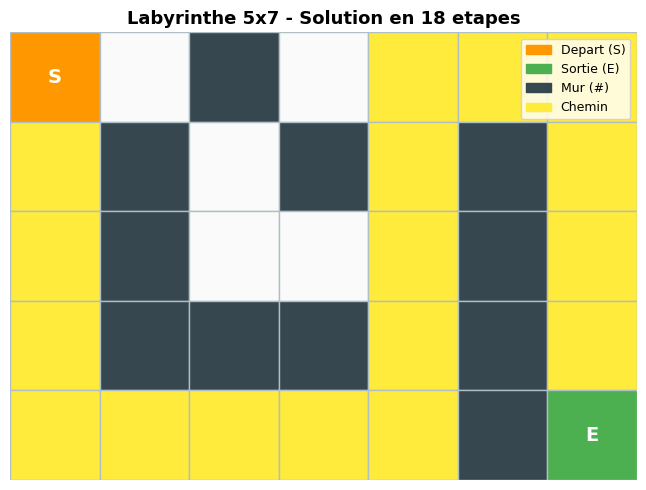

In [18]:
def visualize_maze(problem: MazeProblem, solution_actions: List[str] = None):
    """Visualise le labyrinthe avec optionnellement le chemin solution."""
    fig, ax = plt.subplots(figsize=(max(problem.cols, 6), max(problem.rows, 4)))
    
    # Calculer le chemin solution
    path_cells = set()
    if solution_actions:
        state = problem.initial_state()
        path_cells.add(state)
        for a in solution_actions:
            state = problem.transition(state, a)
            path_cells.add(state)
    
    # Dessiner les cellules
    for r in range(problem.rows):
        for c in range(problem.cols):
            cell = problem.maze[r][c]
            
            if cell == '#':
                color = '#37474F'  # Mur sombre
            elif (r, c) == problem.start_pos:
                color = '#FF9800'  # Depart orange
            elif (r, c) == problem.exit_pos:
                color = '#4CAF50'  # Sortie vert
            elif (r, c) in path_cells:
                color = '#FFEB3B'  # Chemin jaune
            else:
                color = '#FAFAFA'  # Passage
            
            rect = plt.Rectangle((c - 0.5, problem.rows - 1 - r - 0.5), 1, 1,
                                  facecolor=color, edgecolor='#B0BEC5', linewidth=1)
            ax.add_patch(rect)
            
            if cell == 'S':
                ax.text(c, problem.rows - 1 - r, 'S', ha='center', va='center',
                        fontsize=14, fontweight='bold', color='white')
            elif cell == 'E':
                ax.text(c, problem.rows - 1 - r, 'E', ha='center', va='center',
                        fontsize=14, fontweight='bold', color='white')
    
    ax.set_xlim(-0.5, problem.cols - 0.5)
    ax.set_ylim(-0.5, problem.rows - 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    status = f" - Solution en {len(solution_actions)} etapes" if solution_actions else ""
    ax.set_title(f"Labyrinthe {problem.rows}x{problem.cols}{status}",
                 fontsize=13, fontweight='bold')
    
    # Legende
    legend_patches = [
        mpatches.Patch(color='#FF9800', label='Depart (S)'),
        mpatches.Patch(color='#4CAF50', label='Sortie (E)'),
        mpatches.Patch(color='#37474F', label='Mur (#)'),
    ]
    if solution_actions:
        legend_patches.append(mpatches.Patch(color='#FFEB3B', label='Chemin'))
    ax.legend(handles=legend_patches, loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()


# Afficher le labyrinthe avec la solution
visualize_maze(maze, solution)

### Interpretation : Labyrinthe comme espace d'etats

**Sortie obtenue** : Le labyrinthe est resolu par BFS, qui trouve le chemin le plus court (en nombre d'etapes).

| Propriete | Valeur |
|-----------|--------|
| Taille de la grille | 5x7 |
| Cases accessibles | Variable (hors murs) |
| Facteur de branchement | 1-4 selon la position |
| Cout | Uniforme (1 par deplacement) |

**Points cles** :
1. Le labyrinthe est un cas particulier de graphe implicite : les aretes sont definies par la structure de la grille
2. La BFS garantit la solution optimale car le cout est uniforme
3. Ce meme modele peut representer des problemes de robotique, de pathfinding dans les jeux video, etc.

## 8. Resume

### Concepts cles

| Concept | Definition |
|---------|------------|
| **Espace d'etats** $S$ | Ensemble de toutes les configurations possibles du probleme |
| **Etat initial** $s_0$ | Configuration de depart |
| **Actions** $A(s)$ | Operations applicables dans un etat |
| **Transition** $T(s,a)$ | Fonction qui produit le nouvel etat |
| **Test de but** $G(s)$ | Determine si un etat est une solution |
| **Fonction de cout** $c(s,a,s')$ | Cout associe a une transition |
| **Solution** | Chemin de $s_0$ a un etat but |
| **Solution optimale** | Solution de cout minimal |

### Problemes etudies

| Probleme | Taille $|S|$ | Cout | Difficulte principale |
|----------|-------------|------|-----------------------|
| Aspirateur | 8 | Uniforme | Trivial, sert de modele pedagogique |
| 8-Puzzle | 181 440 | Uniforme | Taille de l'espace, profondeur des solutions |
| Itineraire | Variable | Distances | Couts non uniformes, necessite UCS ou A* |
| Missionnaires | ~16 | Uniforme | Contraintes de validite des etats |
| Labyrinthe | Variable | Uniforme | Structure implicite du graphe |

### Ce qu'il faut retenir

1. **Tout probleme de planification** peut se formaliser comme un probleme de recherche dans un espace d'etats
2. **La taille de l'espace** determine la complexite computationnelle
3. **Le type de cout** (uniforme ou non) determine le choix de l'algorithme
4. **Les proprietes** (observable, deterministe, discret) conditionnent les algorithmes applicables

### Pour aller plus loin

- **Notebook suivant** : [Search-2-Uninformed](Search-2-Uninformed.ipynb) - Algorithmes de recherche non informee (BFS, DFS, UCS)
- **Reference** : Russell & Norvig, *Artificial Intelligence: A Modern Approach*, Chapitre 3

---

**Navigation** : [Index](../README.md) | [Suivant >>](Search-2-Uninformed.ipynb)